In [5]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve, auc)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set style for plots
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

In [7]:
#Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [8]:
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
# Data Exploration
print("Dataset Information:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe(include='all').T)

print("\nMissing Values:")
print(df.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

In [10]:
# Data Preprocessing

# Convert TotalCharges to numeric (empty strings will become NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop customerID as it's not useful for modeling
df.drop('customerID', axis=1, inplace=True)

# Handle missing values (very few in this case)
df.dropna(inplace=True)

# Convert Churn to binary numeric values
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Display processed data info
print("Processed Data Info:")
print(df.info())

Processed Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non

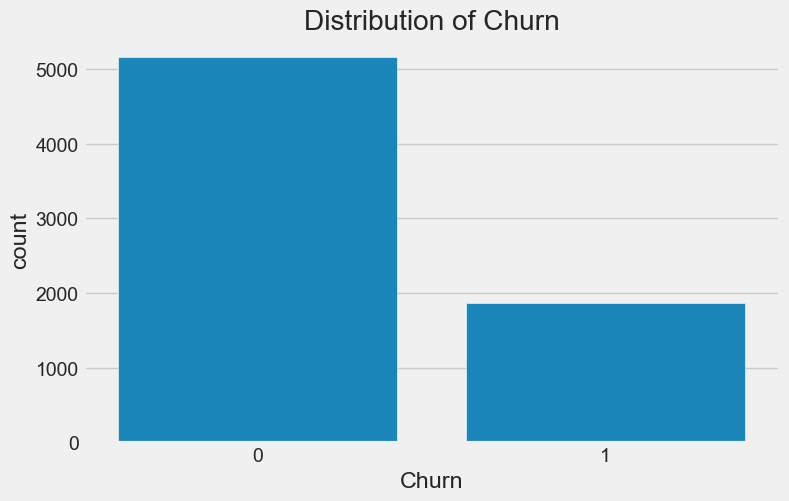

Overall churn rate: 26.58%


In [15]:
# Exploratory Data Analysis (EDA)

# Churn distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()

churn_rate = df['Churn'].mean()
print(f"Overall churn rate: {churn_rate:.2%}")

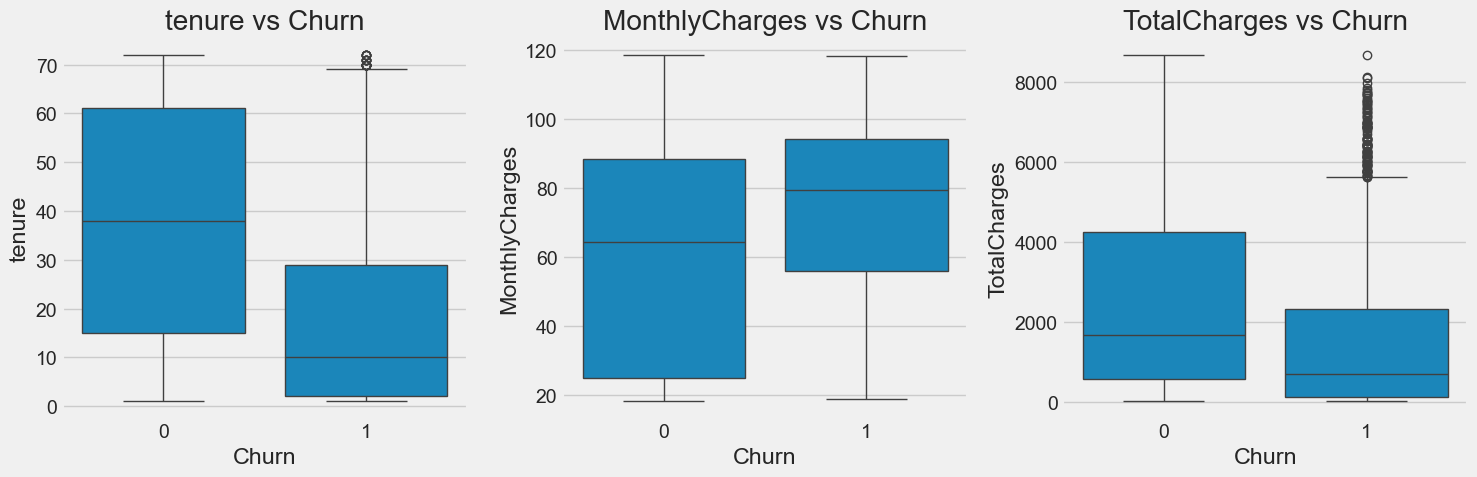

In [20]:
# Numeric features analysis
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.title(f'{feature} vs Churn')
plt.tight_layout()
plt.show()

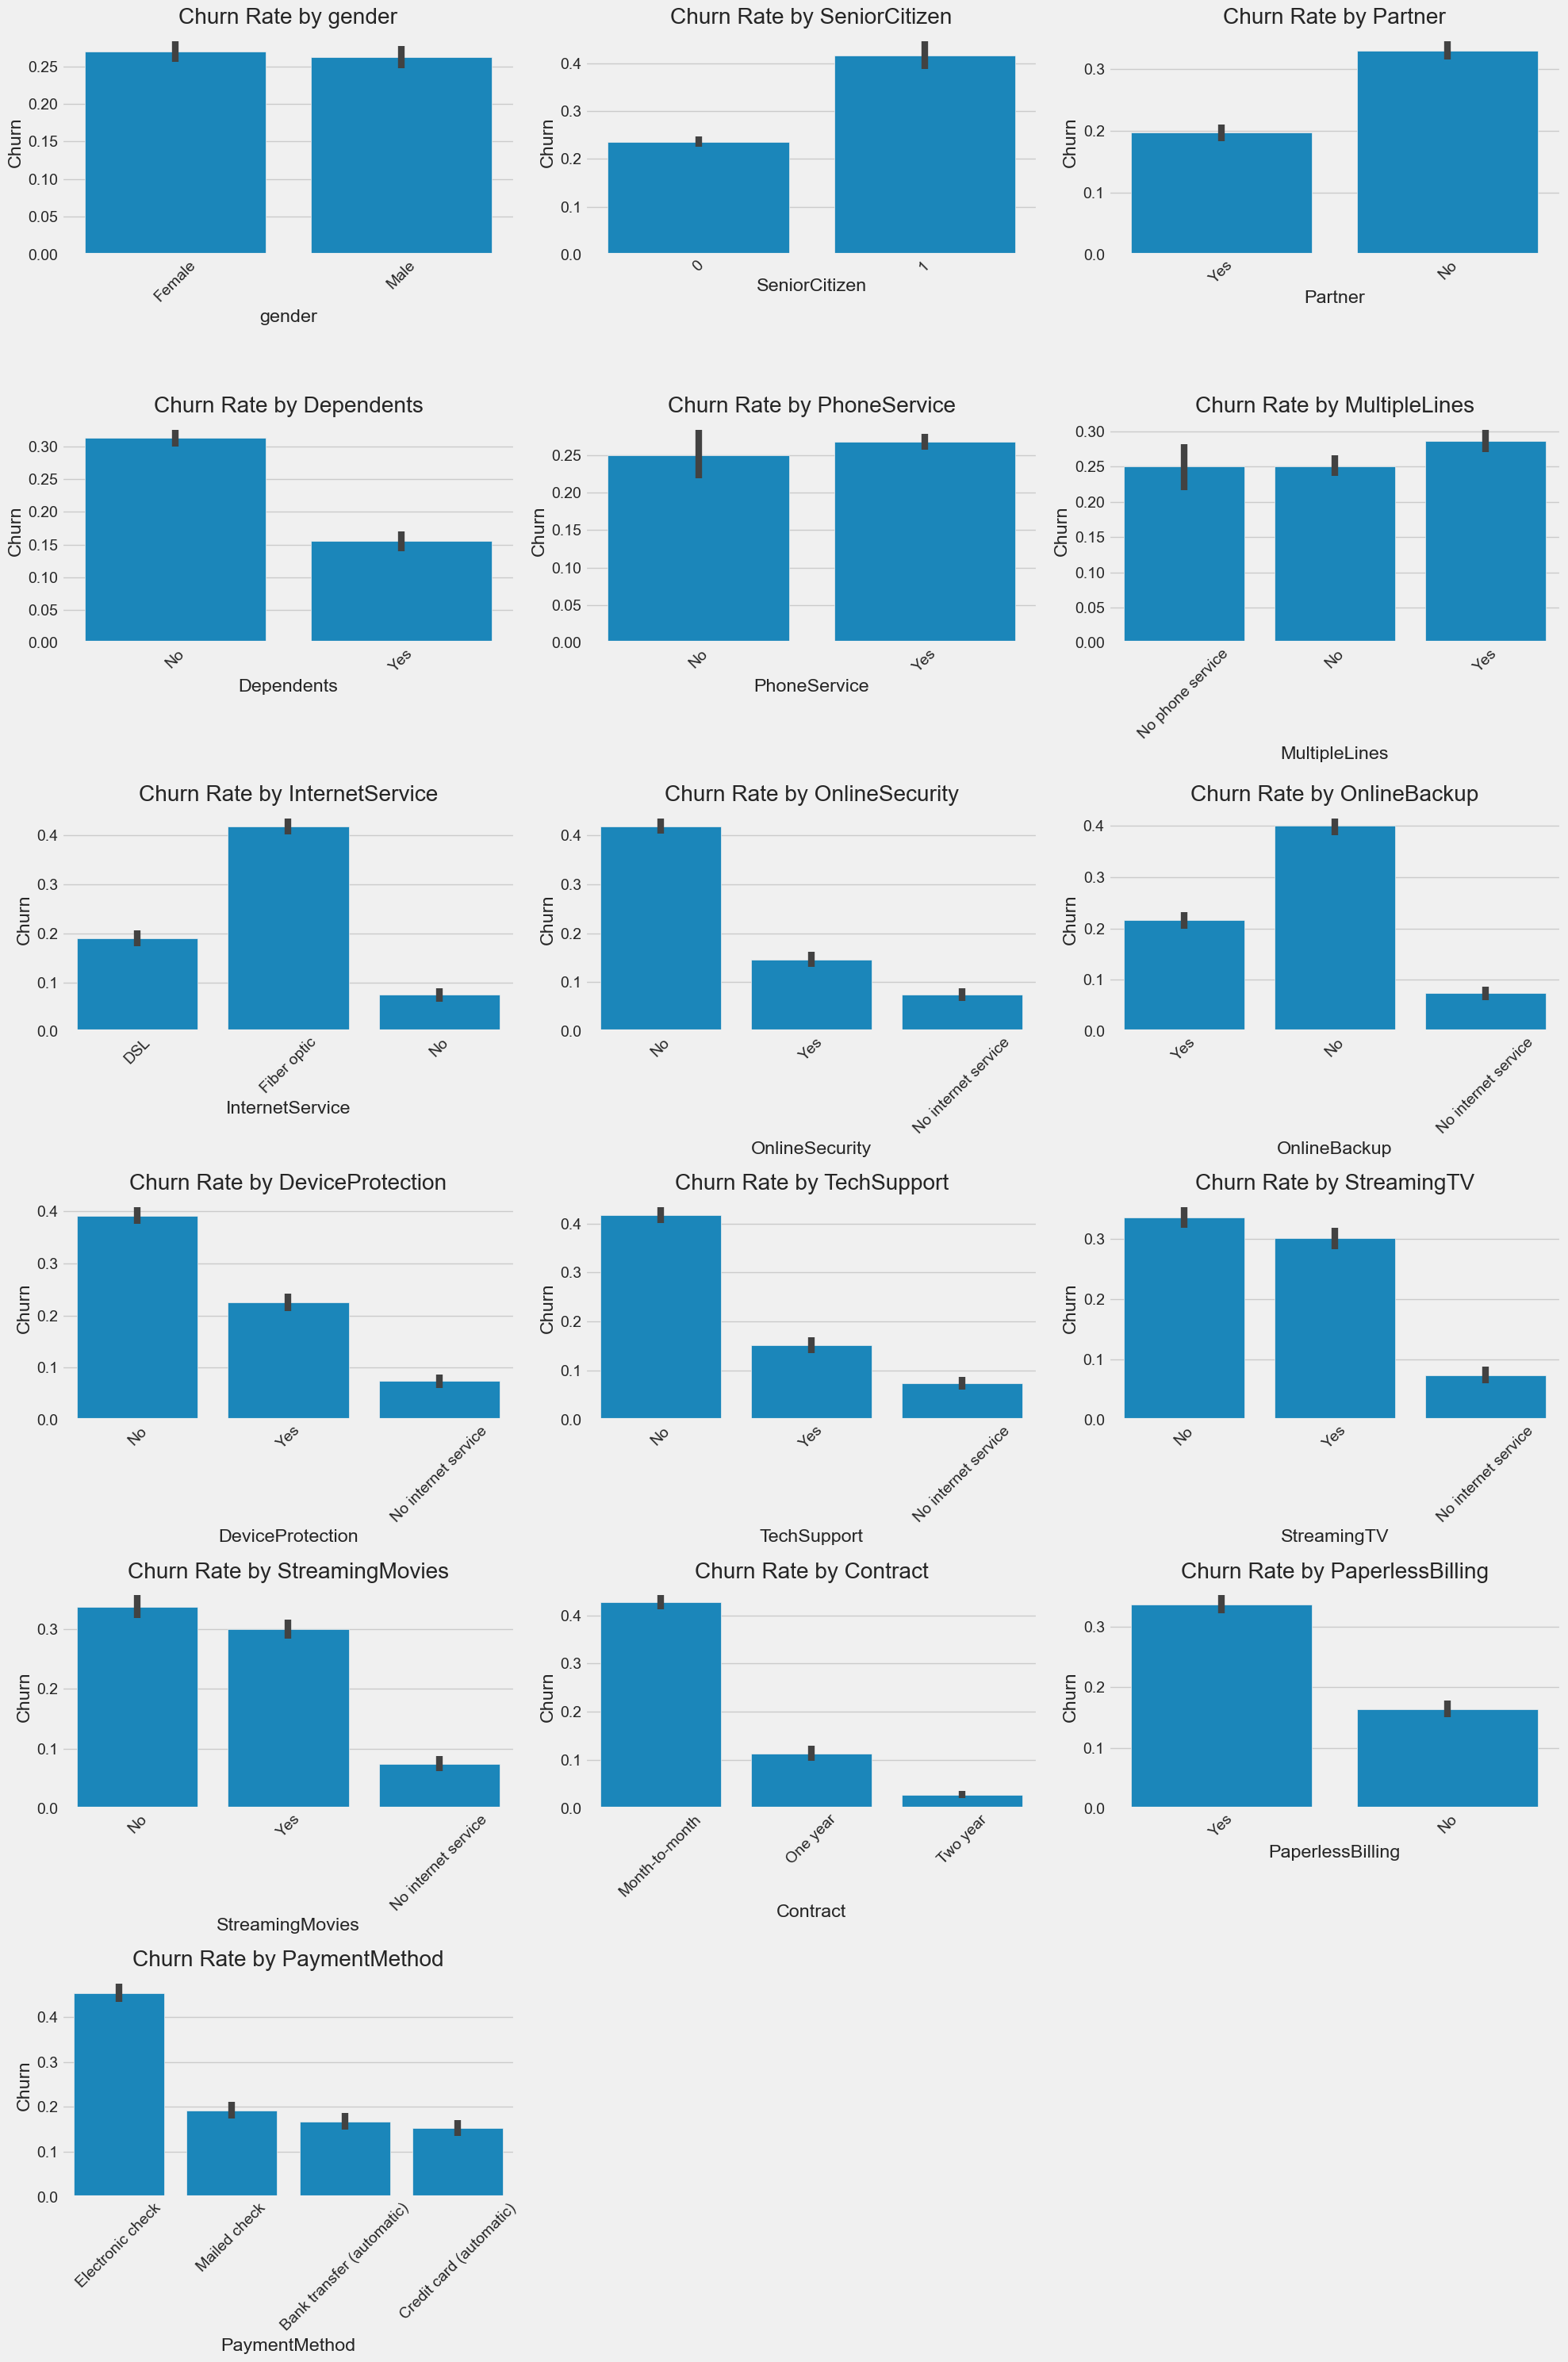

In [21]:
# Categorical features analysis
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                        'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

plt.figure(figsize=(20, 30))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(6, 3, i)
    sns.barplot(x=feature, y='Churn', data=df)
    plt.title(f'Churn Rate by {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

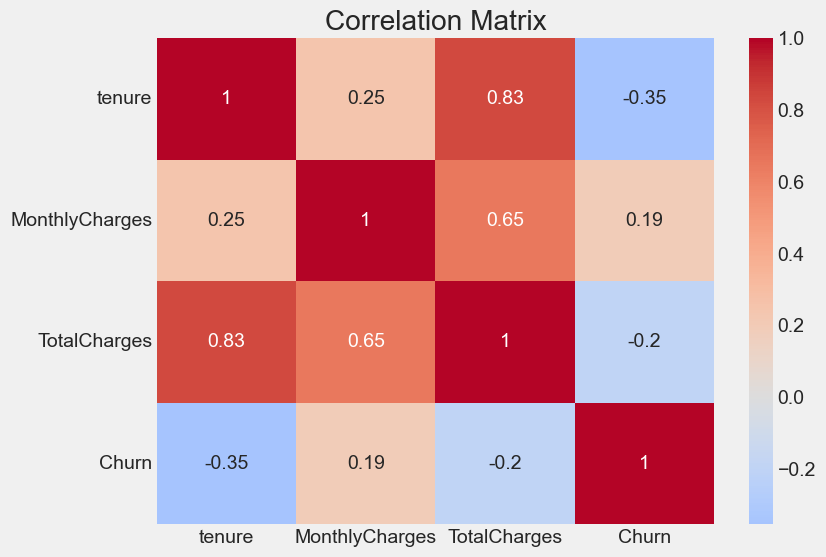

In [23]:
# Correlation analysis
plt.figure(figsize=(8, 6))
corr = df[numeric_features + ['Churn']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [24]:
# Feature Engineering

# Create a new feature: tenure_group
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, np.inf], 
                            labels=['0-1yr', '1-2yr', '2-4yr', '4-5yr', '>5yr'])

# Create a new feature: avg_charge_per_tenure (average monthly charge over tenure)
df['avg_charge_per_tenure'] = df['TotalCharges'] / df['tenure']
df['avg_charge_per_tenure'].fillna(0, inplace=True)

In [25]:
# Prepare data for modeling

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

Training set shape: (5625, 21)
Test set shape: (1407, 21)
Train churn rate: 26.58%
Test churn rate: 26.58%


In [26]:
# Define preprocessing pipelines

# Numeric features pipeline
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'avg_charge_per_tenure']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical features pipeline
categorical_features = [col for col in X.columns if col not in numeric_features]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [27]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

print("Before SMOTE:")
print(f"Class 0: {sum(y_train == 0)}, Class 1: {sum(y_train == 1)}")

print("\nAfter SMOTE:")
print(f"Class 0: {sum(y_train_res == 0)}, Class 1: {sum(y_train_res == 1)}")

Before SMOTE:
Class 0: 4130, Class 1: 1495

After SMOTE:
Class 0: 4130, Class 1: 4130


In [35]:
# Model Building and Evaluation

# Dictionary to store model performance
model_performance = {}

# Function to evaluate models
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store performance
    model_performance[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    #plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Not Churn', 'Churn'], 
                    yticklabels=['Not Churn', 'Churn'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

        # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return model


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



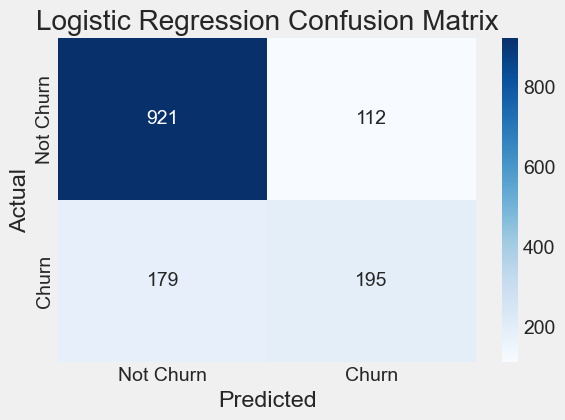

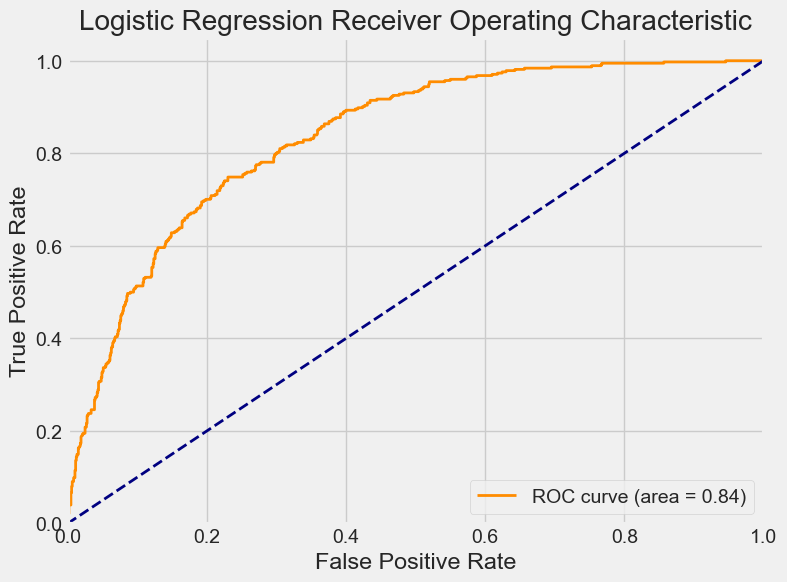

In [36]:
# Logistic Regression
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

logreg = evaluate_model(logreg, "Logistic Regression", 
                       X_train, y_train, X_test, y_test)

Best parameters for Random Forest:
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.65      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



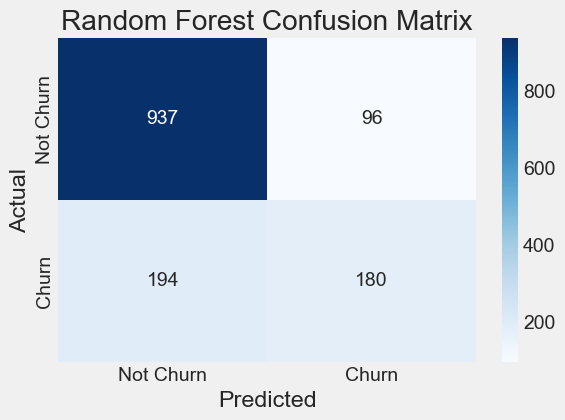

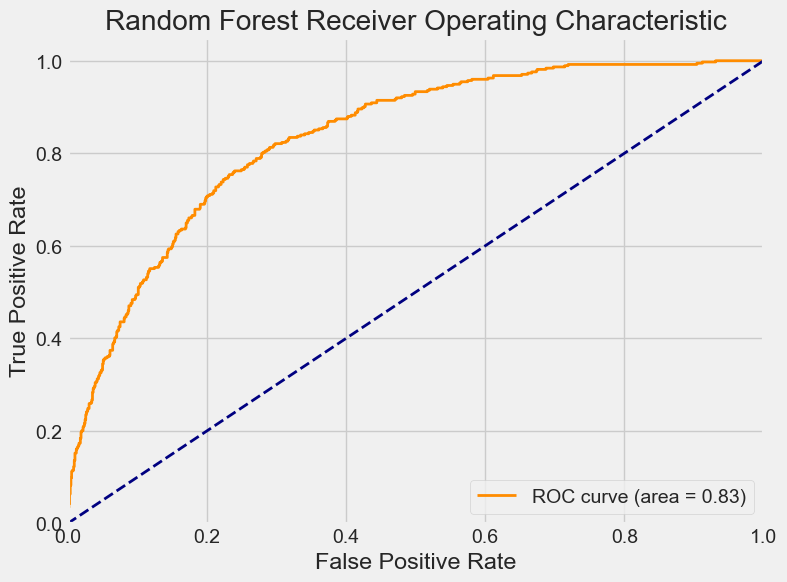

In [37]:
# Random Forest
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:")
print(grid_rf.best_params_)

best_rf = grid_rf.best_estimator_
best_rf = evaluate_model(best_rf, "Random Forest", 
                         X_train, y_train, X_test, y_test)

Best parameters for Gradient Boosting:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



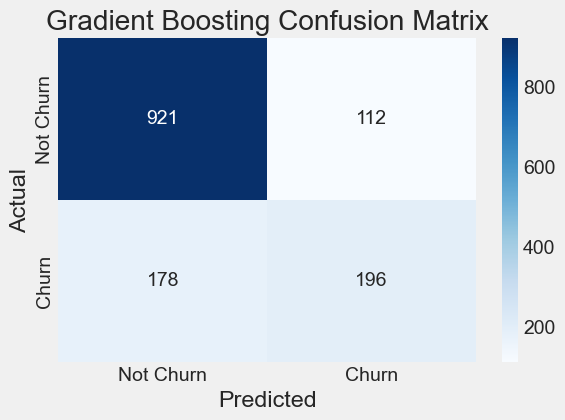

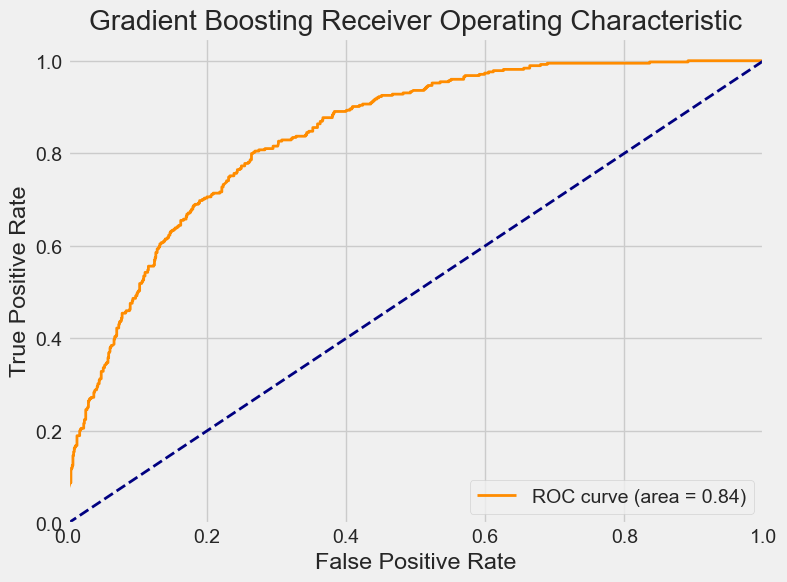

In [38]:
# Gradient Boosting
gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}

grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='f1', n_jobs=-1)
grid_gb.fit(X_train, y_train)

print("Best parameters for Gradient Boosting:")
print(grid_gb.best_params_)

best_gb = grid_gb.best_estimator_
best_gb = evaluate_model(best_gb, "Gradient Boosting", 
                         X_train, y_train, X_test, y_test)

In [39]:
# Compare model performance
performance_df = pd.DataFrame(model_performance).T
performance_df = performance_df.sort_values('F1 Score', ascending=False)

print("Model Performance Comparison:")
performance_df

Model Performance Comparison:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Gradient Boosting,0.793888,0.636364,0.524064,0.574780,0.841147
Logistic Regression,0.793177,0.635179,0.521390,0.572687,0.835134
Random Forest,0.793888,0.652174,0.481283,0.553846,0.834169


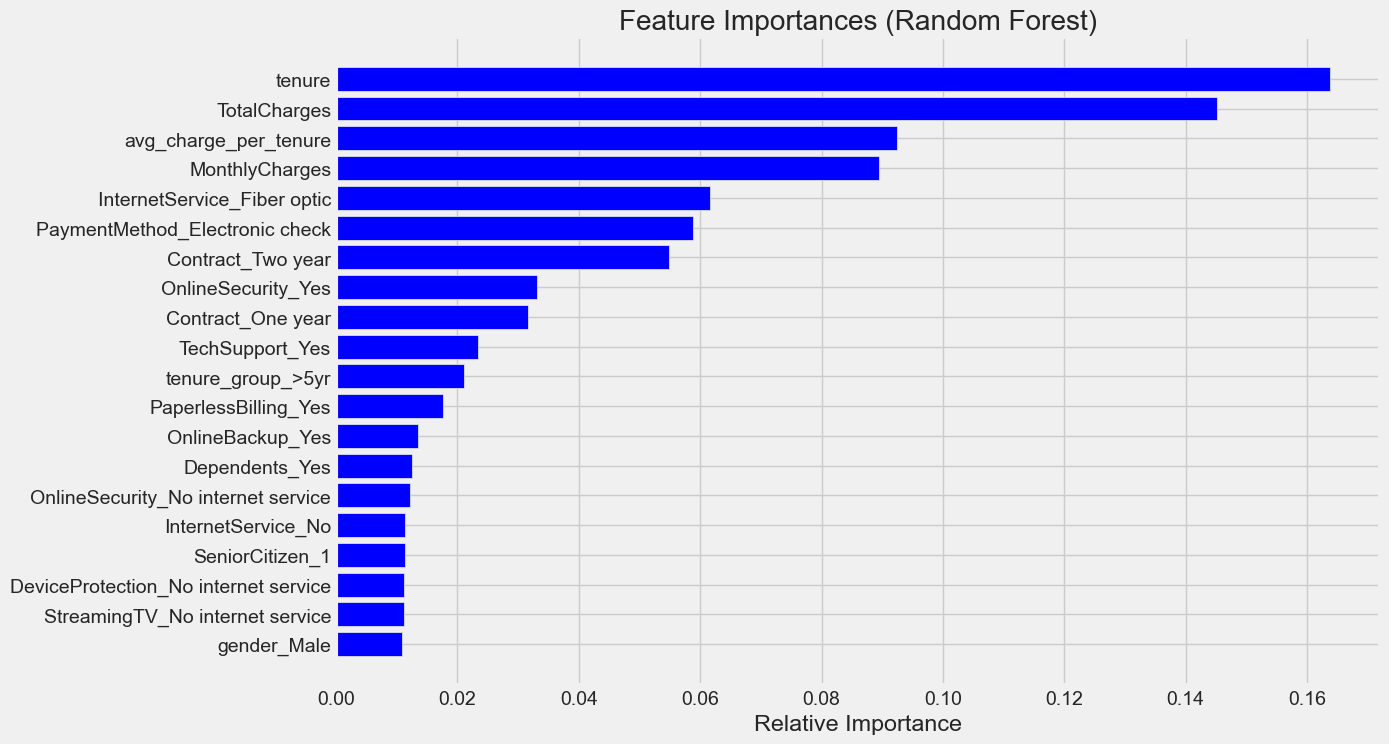

In [40]:
# Feature Importance Analysis (using the best model - Random Forest in this case)

# Get feature names after one-hot encoding
preprocessor.fit(X_train)
numeric_feature_names = numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Get feature importances
importances = best_rf.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Random Forest)")
plt.barh(range(len(indices[:20])), importances[indices[:20]][::-1], color='b', align='center')
plt.yticks(range(len(indices[:20])), [all_feature_names[i] for i in indices[:20]][::-1])
plt.xlabel('Relative Importance')
plt.show()

In [41]:
# Save the best model
joblib.dump(best_rf, 'best_churn_model.pkl')

['best_churn_model.pkl']

In [42]:
# Function to predict churn for new data
def predict_churn(new_data, model=best_rf):
    """
    Predict churn probability for new customer data.
    
    Args:
        new_data: DataFrame with customer data (same format as training data)
        model: Trained model to use for prediction
        
    Returns:
        DataFrame with original data plus churn probability and prediction
    """
    # Make sure new_data has the same columns as training data
    assert set(new_data.columns) == set(X.columns), "Columns don't match training data"
    
    # Reorder columns to match training data
    new_data = new_data[X.columns]
    
    # Predict probabilities
    proba = model.predict_proba(new_data)[:, 1]
    
    # Create output DataFrame
    output = new_data.copy()
    output['Churn_Probability'] = proba
    output['Churn_Prediction'] = (proba >= 0.5).astype(int)
    
    return output

In [43]:
# Business Recommendations based on Analysis

print("Key Insights and Business Recommendations:")
print("""
1. High Churn Drivers:
   - Customers with month-to-month contracts have significantly higher churn rates.
   - Customers without online security, tech support, or device protection are more likely to churn.
   - Electronic check payment method is associated with higher churn.

2. Retention Opportunities:
   - Target customers with 1-2 years tenure as they show moderate churn rates.
   - Focus on customers with high monthly charges but relatively short tenure.
   - Consider special offers for customers using electronic check payment.

3. Product Improvements:
   - Bundle online security and tech support with internet service.
   - Consider contract incentives for month-to-month customers to switch to longer terms.
   - Review pricing strategy for high monthly charge customers.

4. Proactive Retention:
   - Implement early warning system using the predictive model.
   - Create targeted retention campaigns for high-risk customers.
   - Develop loyalty programs for long-tenure customers.
""")

Key Insights and Business Recommendations:

1. High Churn Drivers:
   - Customers with month-to-month contracts have significantly higher churn rates.
   - Customers without online security, tech support, or device protection are more likely to churn.
   - Electronic check payment method is associated with higher churn.

2. Retention Opportunities:
   - Target customers with 1-2 years tenure as they show moderate churn rates.
   - Focus on customers with high monthly charges but relatively short tenure.
   - Consider special offers for customers using electronic check payment.

3. Product Improvements:
   - Bundle online security and tech support with internet service.
   - Consider contract incentives for month-to-month customers to switch to longer terms.
   - Review pricing strategy for high monthly charge customers.

4. Proactive Retention:
   - Implement early warning system using the predictive model.
   - Create targeted retention campaigns for high-risk customers.
   - Develop 

In [44]:
# Save the notebook's output to a file
from IPython.display import HTML
import base64
import io

# Download link for the notebook
def create_download_link(df, title="Download CSV file", filename="churn_analysis_results.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = f'<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    return HTML(html)

# Example usage for downloading model performance
create_download_link(performance_df.reset_index().rename(columns={'index': 'Model'}),
                    "Download Model Performance CSV")